In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [2]:
import tensorflow as tf
from tensorflow import keras
print("The TensorFlow version installed in the Notebook is TensorFlow {}".format(tf.__version__))
print("The TensorFlow version of Keras installed in the Notebook is Keras {}".format(keras.__version__))

The TensorFlow version installed in the Notebook is TensorFlow 2.3.1
The TensorFlow version of Keras installed in the Notebook is Keras 2.4.0


In [3]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

Requirement already up-to-date: gensim in /opt/conda/lib/python3.7/site-packages (3.8.3)
Requirement already up-to-date: keras in /opt/conda/lib/python3.7/site-packages (2.4.3)
Requirement already up-to-date: pandas in /opt/conda/lib/python3.7/site-packages (1.1.4)


In [4]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [5]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [6]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [31]:
ls

training.1600000.processed.noemoticon.csv


In [32]:

df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [33]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [34]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [35]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [36]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 984 ms, sys: 28.3 ms, total: 1.01 s
Wall time: 1.01 s


Text(0.5, 1.0, 'Dataset labels distribuition')

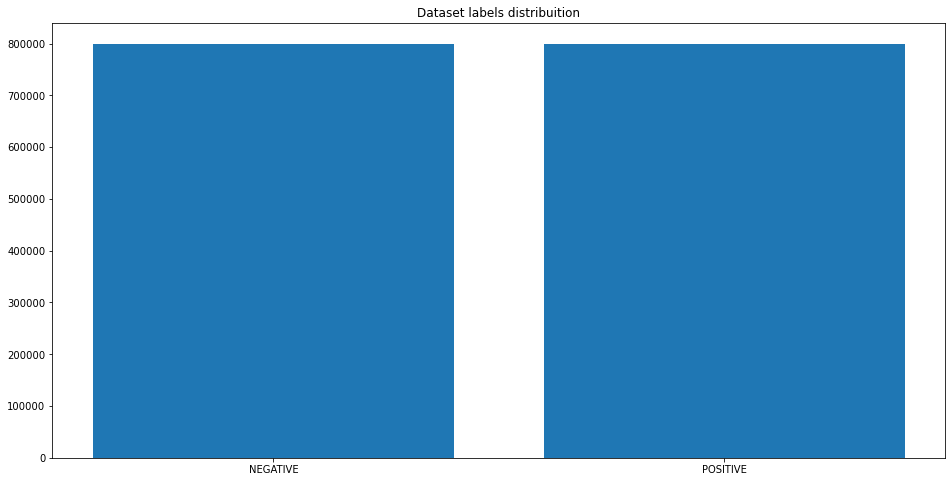

In [37]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [38]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [39]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [40]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 1min 20s, sys: 0 ns, total: 1min 20s
Wall time: 1min 21s


In [41]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [42]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 3.2 s, sys: 390 ms, total: 3.59 s
Wall time: 3.59 s


In [43]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [44]:
w2v_model.build_vocab(documents)

In [45]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [46]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 27min 21s, sys: 9.37 s, total: 27min 30s
Wall time: 15min 32s


(263122363, 295270528)

In [47]:
w2v_model.most_similar("love")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('luv', 0.5731014609336853),
 ('loved', 0.5515363216400146),
 ('loves', 0.5475828647613525),
 ('adore', 0.527254045009613),
 ('amazing', 0.5057379007339478),
 ('looove', 0.49734795093536377),
 ('loveee', 0.4656527042388916),
 ('awesome', 0.4631512761116028),
 ('lovee', 0.4434657692909241),
 ('loooove', 0.4328293204307556)]

Tokenize Text



In [48]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 26.4 s, sys: 114 ms, total: 26.6 s
Wall time: 26.6 s


In [49]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 41.9 s, sys: 650 ms, total: 42.6 s
Wall time: 42.7 s


Label Encoder

In [50]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [51]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [52]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [53]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

Embedding layer

In [54]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [55]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

Build Model

In [56]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


Compile model

In [57]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Callbacks

In [59]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

Train

In [60]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - 602s 535ms/step - loss: 0.5029 - accuracy: 0.7511 - val_loss: 0.4634 - val_accuracy: 0.7808
Epoch 2/8
1125/1125 [==============================] - 601s 534ms/step - loss: 0.4784 - accuracy: 0.7677 - val_loss: 0.4552 - val_accuracy: 0.7835
Epoch 3/8
1125/1125 [==============================] - 600s 534ms/step - loss: 0.4714 - accuracy: 0.7722 - val_loss: 0.4539 - val_accuracy: 0.7859
Epoch 4/8
1125/1125 [==============================] - 601s 535ms/step - loss: 0.4671 - accuracy: 0.7749 - val_loss: 0.4504 - val_accuracy: 0.7872
Epoch 5/8
1125/1125 [==============================] - 601s 534ms/step - loss: 0.4651 - accuracy: 0.7766 - val_loss: 0.4489 - val_accuracy: 0.7888
Epoch 6/8
1125/1125 [==============================] - 600s 533ms/step - loss: 0.4630 - accuracy: 0.7775 - val_loss: 0.4473 - val_accuracy: 0.7895
Epoch 7/8
1125/1125 [==============================] - 599s 532ms/step - loss: 0.4622 - accuracy: 0.7777 - val_loss: 0

Evaluate

In [61]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 48s 154ms/step - loss: 0.4449 - accuracy: 0.7913

ACCURACY: 0.7912874817848206
LOSS: 0.44490620493888855
CPU times: user 47.4 s, sys: 942 ms, total: 48.3 s
Wall time: 49 s


In [65]:
print(history.history)

{'loss': [0.5029484629631042, 0.4784174859523773, 0.47141894698143005, 0.46707865595817566, 0.4650949537754059, 0.4629800319671631, 0.4621637463569641, 0.4610201418399811], 'accuracy': [0.751088559627533, 0.7677300572395325, 0.7721849083900452, 0.7749261856079102, 0.7765798568725586, 0.7774565815925598, 0.7777178883552551, 0.7787838578224182], 'val_loss': [0.4633735418319702, 0.4552105963230133, 0.45388999581336975, 0.45035070180892944, 0.4488612413406372, 0.4473245143890381, 0.4469105303287506, 0.44651445746421814], 'val_accuracy': [0.7808203101158142, 0.7834687232971191, 0.7859452962875366, 0.7871562242507935, 0.7887890338897705, 0.7894921898841858, 0.7899453043937683, 0.7901250123977661], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}


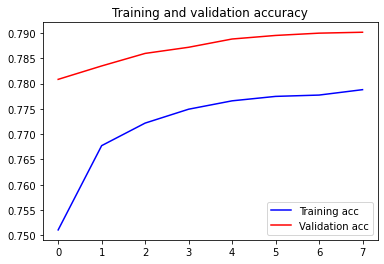

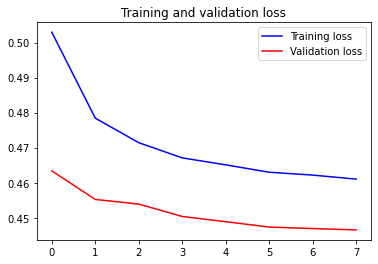

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Predict

In [67]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [68]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [69]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9769854545593262,
 'elapsed_time': 0.3846616744995117}

In [70]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.009802034124732018,
 'elapsed_time': 0.12281489372253418}

In [71]:
predict("i don't know what i'm doing")

{'label': 'NEGATIVE',
 'score': 0.35027551651000977,
 'elapsed_time': 0.11463165283203125}

Confusion Matrix

In [72]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 35s 866ms/step
CPU times: user 33.5 s, sys: 6.83 s, total: 40.3 s
Wall time: 39 s


In [73]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)

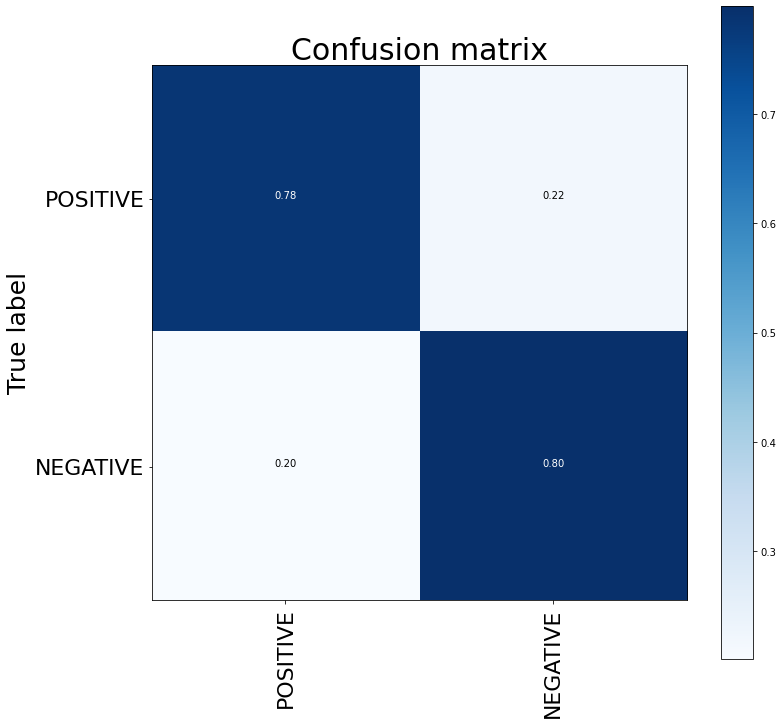

CPU times: user 1.76 s, sys: 60.1 ms, total: 1.82 s
Wall time: 1.82 s


In [74]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

Classification Report

In [75]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.78      0.79    159494
    POSITIVE       0.79      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [76]:
accuracy_score(y_test_1d, y_pred_1d)

0.7912875

Save model

In [87]:
cd working

input/  lib/  working/


In [78]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

OSError: Unable to create file (unable to open file: name = 'model.h5', errno = 30, error message = 'Read-only file system', flags = 13, o_flags = 242)